In [ ]:
#import required packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
import pandas_profiling
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import learning_curve,cross_val_score,validation_curve,train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import PolynomialFeatures

import tensorflow as tf
from keras.layers import Dense
from keras.models import Model, Sequential
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import History
from keras.utils.vis_utils import plot_model as plot
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

%matplotlib inline

In [2]:
#loading dataset to pandas dataframe 
df = pd.read_excel('data_candidate2.xlsx')

y = df['Current Month']
df.head()

,ID,Name,Address,Age,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,...,Feature16,Feature17,Feature18,Feature19,Feature20,Feature21,Feature22,Feature23,Feature24,Current Month
0,1,Renee Horne,"610 Julie Forges Suite 389\nPort Bryan, UT 15509",65,2659.432,3629.1365,2775.4065,2515.4573,2314.9097,2403.5557,...,1910.7119,NaN,2555.2510,2082.2104,2209.1255,2862.3804,NaN,3034.0947,NaN,2291.8096
1,2,Tina Clark,3094 Thomas Station Suite 903\nLake Michaelshi...,36,NaN,3347.3477,NaN,2511.7124,2979.6692,3195.0806,...,NaN,2756.2160,2435.9326,NaN,NaN,2565.6840,3840.0684,2670.0857,2629.6519,3591.0525
2,3,Tina Rose,"165 Anderson Prairie\nFloresborough, NH 27608",22,2282.453,3392.0440,3024.8790,NaN,2492.9480,3272.3347,...,2950.7886,2796.2012,2121.7842,2756.8190,2684.9490,2847.9180,2178.4014,2579.0270,NaN,2988.7327
3,4,Hannah Mcdonald,"309 Smith Park Suite 479\nPeterville, DE 11481",35,NaN,NaN,NaN,3036.1348,3280.9211,2571.1865,...,2303.5906,2681.9558,2491.6313,2687.8845,NaN,NaN,NaN,2467.2250,2838.3267,2440.1326
4,5,Kimberly Ballard,"PSC 8090, Box 7864\nAPO AE 08969",61,3464.405,3130.0159,2657.5356,NaN,NaN,1835.2529,...,NaN,2506.8945,NaN,2446.8420,3170.4944,2891.7024,2462.6643,NaN,2050.0867,2336.4373


In [3]:
pandas_profiling.ProfileReport(df)

Number of variables,29
Number of observations,3000
Total Missing (%),16.5%
Total size in memory,679.8 KiB
Average record size in memory,232.0 B
Numeric,27
Categorical,1
Boolean,0
Date,0
Text (Unique),1
Rejected,0


# FEATURE SELECTION


Most of the times, the data is damaged, or missing, we need to take care of it since Machine Learning models don't work when the data is missing or not a number.

In [4]:
#Check if any feature has missing values > 1/3 of feature shape i.e. for this dataset we discard features having missing values mpre than 1000
total_missing = df.isna().sum()
print(total_missing)
to_delete = total_missing[total_missing>(df.shape[0]/3.)]
to_delete

ID                 0
Name               0
Address            0
Age                0
Feature1         613
Feature2         606
Feature3         594
Feature4         613
Feature5         611
Feature6         618
Feature7         649
Feature8         575
Feature9         605
Feature10        600
Feature11        610
Feature12        606
Feature13        612
Feature14        587
Feature15        575
Feature16        618
Feature17        610
Feature18        611
Feature19        583
Feature20        595
Feature21        558
Feature22        573
Feature23        588
Feature24        567
Current Month      0
dtype: int64


Series([], dtype: int64)

Great! There were no such features having NaNs or missing values more than the set threshold limit. We Now replace these NaNs with mean values accross columns (axis = 1). From distribution observed for each feature none of them are skewed so Mean is used as the value to replace missing values.

In [5]:
imputer = Imputer(missing_values='NaN', strategy='mean', axis = 1)
df.iloc[:, 4:28] = imputer.fit_transform(df.iloc[:, 4:28])
df.head()

,ID,Name,Address,Age,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,...,Feature16,Feature17,Feature18,Feature19,Feature20,Feature21,Feature22,Feature23,Feature24,Current Month
0,1,Renee Horne,"610 Julie Forges Suite 389\nPort Bryan, UT 15509",65,2659.432000,3629.136500,2775.406500,2515.457300,2314.909700,2403.5557,...,1910.711900,2619.698739,2555.251000,2082.210400,2209.125500,2862.380400,2619.698739,3034.094700,2619.698739,2291.8096
1,2,Tina Clark,3094 Thomas Station Suite 903\nLake Michaelshi...,36,2728.098422,3347.347700,2728.098422,2511.712400,2979.669200,3195.0806,...,2728.098422,2756.216000,2435.932600,2728.098422,2728.098422,2565.684000,3840.068400,2670.085700,2629.651900,3591.0525
2,3,Tina Rose,"165 Anderson Prairie\nFloresborough, NH 27608",22,2282.453000,3392.044000,3024.879000,2715.150095,2492.948000,3272.3347,...,2950.788600,2796.201200,2121.784200,2756.819000,2684.949000,2847.918000,2178.401400,2579.027000,2715.150095,2988.7327
3,4,Hannah Mcdonald,"309 Smith Park Suite 479\nPeterville, DE 11481",35,2731.795556,2731.795556,2731.795556,3036.134800,3280.921100,2571.1865,...,2303.590600,2681.955800,2491.631300,2687.884500,2731.795556,2731.795556,2731.795556,2467.225000,2838.326700,2440.1326
4,5,Kimberly Ballard,"PSC 8090, Box 7864\nAPO AE 08969",61,3464.405000,3130.015900,2657.535600,2665.526294,2665.526294,1835.2529,...,2665.526294,2506.894500,2665.526294,2446.842000,3170.494400,2891.702400,2462.664300,2665.526294,2050.086700,2336.4373


# FEATURE SCALING

Reasons to scale features is generally the best way to control the variations in input and also it makes algorithm to compute fast.
For most applications, Standardization is recommended. Min Max Scaling is recommended for Neural Networks. 
1. __Min Max Scaling__: 
Will scale the input to have minimum of 0 and maximum of 1. That is, it scales the data in the range of [0, 1] This is useful when the parameters have to be on same positive scale. But in this case, the outliers are lost. 
$$X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}}$$

2. __Standardization__:
Will scale the input to have mean of 0 and variance of 1. 
$$X_{stand} = \frac{X - \mu}{\sigma}$$

In [6]:
feature_cols = [col for col in df.columns if col not in ['Name', 'Address','Current Month']]
scaler = StandardScaler().fit(df[feature_cols])
df[feature_cols] = scaler.transform(df[feature_cols])    
df.describe()


,ID,Age,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,...,Feature16,Feature17,Feature18,Feature19,Feature20,Feature21,Feature22,Feature23,Feature24,Current Month
count,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,...,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3000.000000
mean,5.691743e-17,1.931834e-16,3.805654e-16,5.222489e-16,5.009002e-16,4.180360e-16,7.883694e-16,-5.199544e-16,1.959174e-16,-1.741940e-16,...,-1.441440e-16,1.869245e-16,-5.998628e-16,-5.471179e-16,2.166579e-16,1.118069e-15,-2.930989e-16,2.401042e-16,3.381184e-16,2849.121100
std,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,...,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,645.226321
min,-1.731474e+00,-1.695704e+00,-4.314856e+00,-3.986946e+00,-3.412994e+00,-4.201513e+00,-3.854589e+00,-3.670556e+00,-5.012935e+00,-3.801632e+00,...,-3.797924e+00,-3.468557e+00,-4.073669e+00,-4.260675e+00,-3.537364e+00,-3.775709e+00,-3.320307e+00,-3.378913e+00,-3.743631e+00,500.000000
25%,-8.657368e-01,-8.623157e-01,-5.640727e-01,-5.747139e-01,-5.692916e-01,-5.523396e-01,-5.830566e-01,-5.420972e-01,-5.468969e-01,-5.486667e-01,...,-5.433702e-01,-5.635750e-01,-5.589230e-01,-5.487763e-01,-5.526412e-01,-5.737719e-01,-5.668015e-01,-5.458536e-01,-5.561619e-01,2410.389900
50%,0.000000e+00,-2.892782e-02,3.691562e-03,4.214552e-03,-5.652761e-03,-1.127571e-02,7.472000e-04,4.103202e-03,6.134286e-03,-4.386858e-03,...,5.389241e-03,1.024828e-02,8.229053e-03,4.904065e-03,1.255675e-02,8.820360e-03,1.711997e-02,1.718652e-02,-1.342289e-04,2831.518500
75%,8.657368e-01,9.155785e-01,5.314039e-01,5.431640e-01,5.697879e-01,5.736010e-01,5.357321e-01,5.827604e-01,5.828612e-01,5.333504e-01,...,5.385258e-01,5.380623e-01,5.447888e-01,5.265277e-01,5.599367e-01,5.772657e-01,5.476216e-01,5.340294e-01,5.022079e-01,3278.422075
max,1.731474e+00,1.693407e+00,5.177787e+00,4.394916e+00,3.794291e+00,3.837751e+00,5.086841e+00,3.774900e+00,3.373036e+00,4.365314e+00,...,4.296314e+00,3.973100e+00,3.941261e+00,3.360178e+00,3.654903e+00,4.659902e+00,3.698990e+00,3.743477e+00,4.111649e+00,5000.000000


After Scale tranform the numerical features now have 0 mean and unit standard deviation.

# FEATURE EXTRACTION

We generally rule out any highly co related features from the dataset. Checking the correlation matrix below will indicate how correlated each feature is with the rest.

In [7]:
df.corr()

,ID,Age,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,...,Feature16,Feature17,Feature18,Feature19,Feature20,Feature21,Feature22,Feature23,Feature24,Current Month
ID,1.000000,0.008111,-0.005865,0.003082,-0.000002,-0.010151,0.020509,-0.019175,-0.023763,-0.003486,...,-0.015293,-0.022572,-0.019412,0.009979,-0.012155,0.020163,-0.007118,0.042929,-0.020047,0.003294
Age,0.008111,1.000000,-0.001791,-0.001430,0.008000,-0.025666,0.005719,-0.002212,-0.020206,-0.004341,...,0.002341,-0.009746,0.000936,0.008769,0.014663,0.018003,0.000599,0.033269,0.011374,-0.010940
Feature1,-0.005865,-0.001791,1.000000,0.034014,0.018998,0.052761,0.006731,0.016783,0.047962,0.005113,...,0.043508,0.005518,0.043458,0.008821,0.014736,-0.014452,0.048387,0.042669,0.016886,0.230442
Feature2,0.003082,-0.001430,0.034014,1.000000,0.020066,0.010281,0.030366,-0.000201,0.031303,0.000734,...,0.017641,0.033563,0.027485,0.004303,0.014888,-0.005998,0.032194,0.026102,0.046304,0.155066
Feature3,-0.000002,0.008000,0.018998,0.020066,1.000000,0.028797,0.038617,0.005870,0.037294,0.019864,...,0.028713,0.044432,-0.007049,0.035006,0.015941,0.012734,0.020745,0.028917,0.000058,0.075842
Feature4,-0.010151,-0.025666,0.052761,0.010281,0.028797,1.000000,0.048400,0.070792,0.027790,0.037369,...,0.028553,0.030959,0.012501,-0.019806,0.010669,0.029167,0.014527,0.034230,0.045174,0.242060
Feature5,0.020509,0.005719,0.006731,0.030366,0.038617,0.048400,1.000000,0.008091,0.060850,0.063329,...,0.027003,0.012569,0.054609,0.025049,0.021903,-0.028745,0.031521,0.003841,0.012280,0.192841
Feature6,-0.019175,-0.002212,0.016783,-0.000201,0.005870,0.070792,0.008091,1.000000,0.023579,0.048738,...,0.060211,0.015308,0.022780,0.042860,0.024407,0.039098,0.017739,0.030907,0.004222,0.116650
Feature7,-0.023763,-0.020206,0.047962,0.031303,0.037294,0.027790,0.060850,0.023579,1.000000,-0.001035,...,0.014360,0.018921,0.025472,0.010087,0.006190,-0.004338,0.039978,0.018643,0.017786,0.251015
Feature8,-0.003486,-0.004341,0.005113,0.000734,0.019864,0.037369,0.063329,0.048738,-0.001035,1.000000,...,0.045795,0.037416,0.005696,0.021133,0.021725,0.024499,0.025544,0.028674,0.035125,0.188706


In [8]:
pandas_profiling.ProfileReport(df)

Number of variables,29
Number of observations,3000
Total Missing (%),0.0%
Total size in memory,679.8 KiB
Average record size in memory,232.0 B
Numeric,27
Categorical,1
Boolean,0
Date,0
Text (Unique),1
Rejected,0


Check most important features and choose a subset of the most imoortant features for training.

In [9]:
dataset1= df.copy()
dataset1.drop(['Address','Name','Current Month'],axis=1,inplace=True)
Y = df['Current Month']
# feature extraction
model = ExtraTreesRegressor()
model.fit(dataset1, Y)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(dataset1.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
          

Feature ranking:
1. feature 17 (0.091280)
2. feature 23 (0.078589)
3. feature 8 (0.071327)
4. feature 13 (0.064457)
5. feature 24 (0.052457)
6. feature 5 (0.051699)
7. feature 2 (0.047802)
8. feature 11 (0.044415)
9. feature 6 (0.040419)
10. feature 18 (0.035374)
11. feature 9 (0.033565)
12. feature 22 (0.033126)
13. feature 20 (0.033021)
14. feature 15 (0.031914)
15. feature 3 (0.031441)
16. feature 19 (0.028650)
17. feature 16 (0.025130)
18. feature 21 (0.024814)
19. feature 14 (0.024169)
20. feature 4 (0.024049)
21. feature 1 (0.023726)
22. feature 0 (0.022796)
23. feature 12 (0.021969)
24. feature 7 (0.021336)
25. feature 25 (0.021254)
26. feature 10 (0.021223)


There seems to no two highly correlated feature. This is indicated by high negative coeficcient or high positive coefficient int the range [-1,1]

In [10]:
#removing lesser important features. Uncomment and check the metrics.
#dataset1= dataset1.copy()
#cols = [19,12,1,16,25,7,0,10,21,14,4]
#dataset1.drop(dataset1.columns[cols],axis=1,inplace=True)
Y = df['Current Month']
dataset1

,ID,Age,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,...,Feature15,Feature16,Feature17,Feature18,Feature19,Feature20,Feature21,Feature22,Feature23,Feature24
0,-1.731474,0.693342,-0.080880,2.122386,0.172758,-0.426200,-0.830554,-0.672530,-0.047459,-0.556032,...,-0.218478,-1.719899,-0.165400,-0.328730,-1.387453,-1.095200,0.371943,-0.157497,0.771856,-0.147502
1,-1.730319,-0.917875,0.073397,1.487623,0.066129,-0.434645,0.646219,1.140129,-0.293976,-1.325913,...,-0.917393,0.067189,0.150714,-0.591645,0.074014,0.076042,-0.290421,2.533551,-0.054185,-0.125382
2,-1.729164,-1.695704,-0.927856,1.588307,0.735050,0.024108,-0.435039,1.317047,-1.075436,0.167391,...,-0.133419,0.554066,0.243302,-1.283864,0.139001,-0.021339,0.339656,-1.130606,-0.260823,0.064635
3,-1.728009,-0.973434,0.081703,0.101019,0.074462,0.747929,1.315454,-0.288641,-0.894250,-1.184709,...,0.033918,-0.860931,-0.021240,-0.468914,-0.016979,0.084386,0.080417,0.089689,-0.514534,0.338391
4,-1.726855,0.471105,1.727692,0.998058,-0.092914,-0.087794,-0.051654,-1.973991,-0.662203,0.135190,...,0.459261,-0.069615,-0.426605,-0.085741,-0.562392,1.074462,0.437403,-0.503775,-0.064532,-1.413447
5,-1.725700,-1.640144,-0.150357,0.070875,1.828772,0.797313,1.596241,0.523807,-1.040833,1.174065,...,0.015564,-0.309133,0.075292,0.837594,-0.948342,-1.304948,0.062219,-0.473625,1.539868,1.429125
6,-1.724545,0.304427,1.846668,0.177602,1.759373,-0.034739,-0.116733,-0.474499,2.748958,0.189674,...,-0.276231,0.684793,0.172890,-1.902360,-2.965129,-0.503261,-0.128610,0.333128,0.163003,0.745521
7,-1.723391,-0.084487,0.081175,0.877731,0.836817,-0.193650,0.225839,-0.987346,1.601704,-0.659601,...,1.780598,-1.412825,-0.167982,-0.189178,-0.158282,-0.171116,-0.626419,0.318121,-0.483003,-1.999302
8,-1.722236,-0.306724,0.305169,-0.579241,0.985888,-0.404835,-0.026173,0.306943,0.529293,0.311137,...,-0.988713,0.724766,-0.849134,-1.246037,1.465638,0.308856,0.401616,0.309013,0.311560,2.272932
9,-1.721081,-0.195605,-2.294478,-0.229832,-0.312211,-0.269558,0.828576,0.567504,1.045444,0.820136,...,1.077883,-1.242291,0.753908,-0.335804,-0.249956,-0.247086,0.249504,0.121810,-0.389903,0.596569


# MACHINE LEARNING MODELS 

In [11]:
def plot_validation_curve(scores,param_range,param_name,scoring='r2'):
    """This function plot validation curve.
    
    Parameters:
        scores: scores obtained from validation_curve() method
        param_range: list of range of parameters passed as 'param_range' in validation_curve() method
        scoring: str
    """
    n=len(param_range)
    if scoring=='r2':
        train_score=[scores[0][i].mean() for i in range (0,n)]
        test_score=[scores[1][i].mean() for i in range (0,n)]
    elif scoring=='neg_mean_squared_error':
        train_score=[np.sqrt(-scores[0][i].mean()) for i in range (0,n)]
        test_score=[np.sqrt(-scores[1][i].mean()) for i in range (0,n)]

    fig=plt.figure(figsize=(8,6))
    plt.plot(param_range,train_score,label='Train')
    plt.plot(param_range,test_score,label='Test')
    plt.xticks=param_range
    plt.title("Validation curve of {}".format(param_name),size=12)
    plt.legend()
    plt.show()

# LINEAR REGRESSION

A Linear Regression Model with R^2 as metric.

In [12]:
lr=LinearRegression()
scores=cross_val_score(lr,dataset1,Y,n_jobs=-1,cv=10,scoring='r2')
print('R2: ',np.sqrt(scores).mean())

R2:  0.7316518941075373



To calculate RMSE.

In [13]:
lr=LinearRegression()
scores=cross_val_score(lr,dataset1,Y,n_jobs=-1,cv=10,scoring='neg_mean_squared_error')
print('RMSE: ',np.sqrt(-scores).mean())

RMSE:  438.0927643058925


So with linear regression,

R-squared=0.73

RMSE=438.09

RMSE of above model is 438.1 which means that there's an average error of 438.1 minutes in prediction of Call volume of current month.

# Ridge Regression

In [14]:
ridge=Ridge(alpha=0.1,random_state=42)
scores=cross_val_score(ridge,dataset1,Y,n_jobs=-1,cv=10,scoring='r2')
print('R2: ',np.sqrt(scores).mean())

R2:  0.7316522323877002


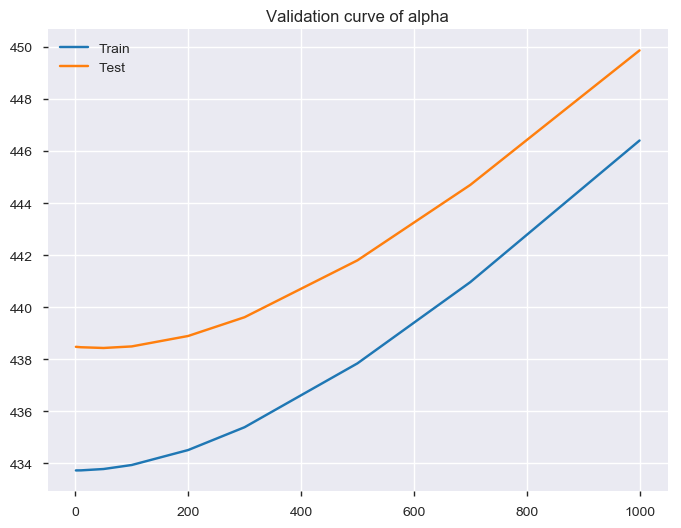

In [15]:
ridge=Ridge(random_state=42)
param_name='alpha'
param_range = [1,10,50,100,200,300,500,700,1000]
#param_range=[1,10,100,800,900,1000,1200,1400,1600,1800,2000]
#scoring='r2'
scoring='neg_mean_squared_error'
curve=validation_curve(ridge,dataset1,Y,scoring=scoring,cv=10,param_name=param_name,
    param_range=param_range,n_jobs=-1)

n=len(param_range)
'''if scoring=='r2':
    train_score=[curve[0][i].mean() for i in range (0,n)]
    test_score=[curve[1][i].mean() for i in range (0,n)]
elif scoring=='neg_mean_squared_error':
    train_score=[np.sqrt(-curve[0][i].mean()) for i in range (0,n)]
    test_score=[np.sqrt(-curve[1][i].mean()) for i in range (0,n)]
    '''

plot_validation_curve(curve,param_range,param_name,scoring)

From above plot It can be seen that Train and Test scores are increasing after alpha=600.

Even at alpha=0, difference between RMSE is not much, so there is no objectionable overfitting. As alpha is increased, bias is increasing and so the RMSE.

As linear regression is not overfitting the model, using Ridge regression is not necessary.

# POLYNOMIAL REGRESSION WITH DEGREE 2 & 3

In [18]:
polynomial_features= PolynomialFeatures(degree=2, include_bias=False)
model = LinearRegression()
x_poly = polynomial_features.fit_transform(dataset1)
scores=cross_val_score(model,x_poly,Y,n_jobs=-1,cv=10,scoring='r2')
print('R2: ',np.sqrt(scores).mean())
#scores


R2:  0.6749996386371924


In [ ]:
scores=cross_val_score(model,x_poly,Y,n_jobs=-1,cv=10,scoring='neg_mean_squared_error')
print('RMSE: ',np.sqrt(-scores).mean())

The RMSE values for both quadratic and linear regression is slightly different, hence we can say that both will give 
approximately similar results. But linear regression still works better with better R-squared and lower RMSE.



In [ ]:
polynomial_features= PolynomialFeatures(degree=3, include_bias=False)
model = LinearRegression()
x_poly = polynomial_features.fit_transform(dataset1)
scores=cross_val_score(model,x_poly,Y,n_jobs=-1,cv=10,scoring='r2')
print('R2: ',np.sqrt(scores).mean())
scores

A negative R-sqaured signifies a poor model choice for the data.

In [ ]:
scores=cross_val_score(lr,x_poly,Y,n_jobs=-1,cv=10,scoring='neg_mean_squared_error')
print('RMSE: ',np.sqrt(-scores).mean())

A very high RMSE implies degree 3 polynomial regression is a poor choice for the dataset and there is high bias.

# NEURAL NETWORK

This approach utilises building a densely connected neural network with one output unit for a continous value to predict call volume.
So far, the features were standardised to feed into machine learning models. Neural network are very sensitive to non-normalized data. In this approach, the data is scaled to a fixed range - usually 0 to 1.
The cost of having this bounded range - in contrast to standardization - is that we will end up with smaller standard deviations, which can suppress the effect of outliers.

In [ ]:
feature_cols = [col for col in df.columns if col not in ['Name', 'Address','Current Month']]
scaler = MinMaxScaler().fit(df[feature_cols])
df[feature_cols] = scaler.transform(df[feature_cols])    
df.describe()

Feeding all the features except address and name to the network.

In [ ]:
dataset1= df.copy()
dataset1.drop(['Address','Name'],axis=1,inplace=True)
Y = df['Current Month']

dataset1.describe()

There are 26 features for this dataset.

In [ ]:
df_train = dataset1
df_test = dataset1
scaler = MinMaxScaler()

X_train = scaler.fit_transform(df_train.drop(['Current Month'],axis=1).as_matrix())
y_train = scaler.fit_transform(df_train['Current Month'].as_matrix().reshape(-1, 1))
#y_train = df_train['Close'].as_matrix()


print(X_train.shape)
print(y_train.shape)

#print(np.max(y_test),np.max(y_train),np.min(y_test),np.min(y_train))

Build the baseline Model and train.

Activation used in the hidden layers is RELU and output neuron with activation LINEAR. The initial learning rate is set to 0.0001, loss for the network is mean squared error to optimise using ADAM optimizer and metrics to evaluate is Mean Absolute error.

In [ ]:
def build_model(initial_learning_rate):
    model = Sequential([
    Dense(64, activation=tf.nn.relu,
                       input_shape=(X_train.shape[1],)),
    Dense(64, activation=tf.nn.relu), Dense(64, activation=tf.nn.relu)])
    model.add(Dense(1, activation='linear'))

    #optimizer = tf.train.AdamOptimizer(0.001)

    
    model.compile(optimizer=Adam(lr=initial_learning_rate), loss='mse', metrics=['mae'])
    return model
   





model = build_model(0.0001)

print("Model compiled successfully!")
print("Model's Summary: ")
print(model.summary())
print(model.output_shape)

plot(model, to_file='./test1_model_gt_new.png')   #check how the model looks like
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
json_string = model.to_json()
open('./test_1_architecture_gt_new.json', 'w').write(json_string)
# The patience parameter is the amount of epochs to check for improvement






checkpointer = ModelCheckpoint(filepath='./check/epoch_{epoch:02d}.hdf5', verbose=2, save_best_only=False,monitor='loss' , save_weights_only=True, mode='auto', period=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.3,
                              patience=3, min_lr=1e-15)
    #history = History()
csv_logger = CSVLogger('./log.csv', append=True, separator=';')
history = model.fit(X_train, y_train, nb_epoch=100, verbose=1, shuffle=True, validation_split=0.2, callbacks = [reduce_lr,checkpointer,csv_logger])
print(history)

In [ ]:
f = pd.read_csv("./log.csv", delimiter=";", header=None, index_col=0,skiprows=[0])
f.plot(y=[1,4],label = ['Train','Val'])
